In [1]:
import sys
import tensorflow as tf
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
from skimage.util import montage as montage2d
from glob import glob
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
sys.path.append("..")
from stn_trail_task.interpolation import BilinearInterpolator, BilinearSpatialTransformParams
from stn_trail_task.localization import CoordConvLocalizationLayer, ConvolutionalLocalizationLayer
from stn_trail_task.coords import AddCoordFeatures2D
from stn_trail_task.aff_mnist_data import get_aff_mnist_data
from stn_trail_task.spatial_transform import SimpleSpatialTransformBlock
from stn_trail_task.visualization import show_train_progress

In [3]:
train_img_data, train_img_label, validation_img_data, validation_img_label, test_img_data, test_img_label = get_aff_mnist_data()

In [4]:
input_shape = (40, 40, 1)
image = tf.keras.layers.Input(shape=input_shape)
size_after_transform = 40

st_block = SimpleSpatialTransformBlock(
    localization_layer = ConvolutionalLocalizationLayer(spatial_transform_params_cls=BilinearSpatialTransformParams),
    interpolation_layer = BilinearInterpolator(height_out=size_after_transform, width_out=size_after_transform)
)

x = image
x = st_block(x)
x = tf.keras.layers.Conv2D(32, [7, 7], activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, [5, 5], activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(40, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation=None)(x)

model = tf.keras.models.Model(inputs=image, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
simple_spatial_transform_blo (None, 40, 40, 1)         19494     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        1600      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0     

In [5]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    x = train_img_data, 
    y = train_img_label, 
    batch_size = 128,
    epochs = 6,
    validation_data = (test_img_data,  test_img_label),
    validation_batch_size = 1024,
)

Epoch 1/6
12500/12500 [==============================] - 274s 22ms/step - loss: 1.2478 - accuracy: 0.5373 - val_loss: 0.0676 - val_accuracy: 0.9786
Epoch 2/6
 2528/12500 [=====>........................] - ETA: 3:13 - loss: 0.0764 - accuracy: 0.9755

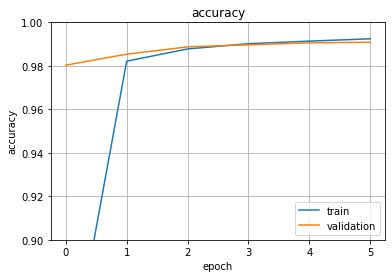

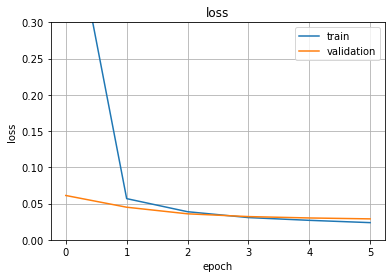

In [10]:
show_train_progress(history)

In [ ]:
model.save(filepath="experiments/Basic_STN_network_0094.h5")